In [1]:
# imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.io import wavfile
from scipy.signal import resample
from tqdm import tqdm
import librosa
from librosa import yin
from librosa.effects import time_stretch
from librosa.effects import trim
from librosa.effects import pitch_shift
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold

In [2]:
## functions def

# nominal = ["gender", "ageRange", "First Language spoken", "Current language used for work/school"]
nominal = ["gender", "ageRange"]
# nominal = ["ageRange"]
ordinal = ["Self-reported fluency level "]
# global variables for encoding and decoding


def create_encoders(df_original):
    """Creates the Encoders for
    OneHotEncoding for nominal categorial data and
    OrdinalEncoding for ordinal categorical data
    and LabelEncoding for the Class label"""

    ohe = OneHotEncoder(sparse=False)
    ohe.fit(df_original[nominal])
    fluency_enc = OrdinalEncoder(categories=[["basic", "intermediate", "advanced", "native"]])
    fluency_enc.fit([["basic"], ["intermediate"], ["advanced"], ["native"]])
    df_original["label"]=df_original["action"]+df_original["object"]
    class_enc = LabelEncoder()
    class_enc.fit(df_original["label"])

    return df_original, ohe, fluency_enc, class_enc


def encode_x(df, ohe, fluency_enc):
    """Encodes X"""
    matrix = ohe.transform(df[nominal])
    # np.hstack((matrix, fluency_enc.transform(df[ordinal])))    
    return matrix


def feature_extraction_1(df, db=20):
    """Loads the audio data and extracts number of samples, max aplitude, and pitch"""
    Xtime = []
    samples_per_audio = []
    max_amp_per_audio = []
    pitch_per_audio = []
    for i, files in tqdm(enumerate(df["path"].values)):
        audio = wavfile.read(files)
        if audio[0]==22050:
            audio = np.array(resample(audio[1], int(len(audio[1]) * (16000 / 22050))), dtype="int16")
        else:
            audio = audio[1]
        max_amp_per_audio.append(np.max(audio))
        audio = audio.astype("float32")
        audio = audio[:64000]
        audio = trim(audio, top_db=db)[0]
        samples_per_audio.append(len(audio))
        audio = time_stretch(audio, rate=len(audio)/21000)
        pitch_per_audio.append(yin(audio, 50, 300,sr=16000))
        Xtime.append(audio)
    return np.array(Xtime), np.array(samples_per_audio), np.array(max_amp_per_audio), np.array(pitch_per_audio)


def feature_extraction_2(Xtime, param={"sr":16000, "n_fft":2048, "hop_length":512, "fmin":50, "n_mfcc":10}):
    """Extracts the MFCC and Deltas from the Mel Spectogram"""
    mfccs = []
    deltas = []
    deltas2 = []
    for audio in Xtime:
        mfcc = librosa.feature.mfcc(audio, **param)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        mfccs.append(mfcc.flatten())
        deltas.append(delta.flatten())
        deltas2.append(delta2.flatten())
    coeff = np.hstack((mfccs, deltas, deltas2))
    return coeff


"""from skimage.measure import block_reduce
def feature_extraction_2b(Xtime, param={"sr":16000, "n_fft":2048, "hop_length":512, "fmin":50, "n_mfcc":10},
                          m=1, n=3, f = np.mean):
    mfccs = []
    deltas = []
    deltas2 = []
    for audio in Xtime:
        mfcc = librosa.feature.mfcc(audio, **param)
    
        # pooling with matrix size MxN, where columns are times (n) 
        # and rows are frequencies (m)

        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc = block_reduce(mfcc, (m,n), f)
        delta = block_reduce(delta, (m,n), f)
        delta2 = block_reduce(delta2, (m,n), f)
        mfccs.append(mfcc.flatten())
        deltas.append(delta.flatten())
        deltas2.append(delta2.flatten())
        
    coeff = np.hstack((mfccs, deltas, deltas2))
    return coeff
"""
           
def data_augmentation(df, indices, Xtime, Xenc, sam, max, y):
    Xtime2 = []
    Xtime3 = []
    Xtime4 = []
    for i, audio in enumerate(Xtime):
        if df.loc[indices[i], "gender"] == "female":
            audio2 = pitch_shift(audio.astype("float32"), sr = 16000, n_steps=-2)
            audio3 = pitch_shift(audio.astype("float32"), sr = 16000, n_steps=-4)
            audio4 = pitch_shift(audio.astype("float32"), sr = 16000, n_steps=-6)
        else:
            audio2 = pitch_shift(audio.astype("float32"), sr = 16000, n_steps=2)
            audio3 = pitch_shift(audio.astype("float32"), sr = 16000, n_steps=4)
            audio4 = pitch_shift(audio.astype("float32"), sr = 16000, n_steps=6)
        Xtime2.append(audio2)
        Xtime3.append(audio3)
        Xtime4.append(audio4)
    Xtime = np.vstack((Xtime, Xtime2, Xtime3, Xtime4))
    pit = []
    for audio in Xtime:
        pit.append(yin(audio, 50, 300,sr=16000))
    pit = np.array(pit)
    Xenc = np.vstack((Xenc, Xenc, Xenc, Xenc))
    sam = np.hstack((sam, sam, sam, sam))
    max = np.hstack((max, max, max, max))
    y = np.hstack((y, y, y, y))
    return Xtime, Xenc, sam, max, pit, y

In [3]:
## PREPARE CROSS VALIDATION DATASET
# data reading
# df = pd.read_csv("/content/drive/MyDrive/project/dsl_data/development.csv")
df = pd.read_csv("development.csv")
# filter out categories not in x_test
"""df = df[df["Self-reported fluency level "]=="native"]
df = df[df['ageRange']!="65+"]
df = df[df['Current language used for work/school']=="English (United States)"]"""

# get fraction of database 
df = df.sample(frac=1).reset_index(drop=True)

# create encoders
df, ohe, fluency_enc, class_enc = create_encoders(df)

# encode training set
Xtrain_encoded = encode_x(df, ohe, fluency_enc)
ytrain = class_enc.transform(df[["label"]])



In [4]:
# CROSS VALIDATION
from sklearn.ensemble import RandomForestClassifier
from numpy.matrixlib.defmatrix import N

best_acc_config = None
best_bal_config = None
best_acc = 0
best_bal = 0
i = 1
I = 48
Xtime, samples_per_audio, max_amp_per_audio, pitch_per_audio = feature_extraction_1(df)

"""hyperparameters = {
    "n_estimators":[1000],
    "max_depth": [None],
    "criterion":["gini", "entropy"],
    "min_samples_split":[2, 5, 10],
    "max_features":["sqrt", "log2"],
    "bootstrap":[True, False],
    "class_weight":[None, "balanced"]
}
"""
configs = [{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini',
            'max_depth': None, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 1000}]
params = [
    {"sr":16000, "n_fft":2048, "hop_length":512, "fmin":50, "n_mfcc":10},
]

for par in params:
    #for config in ParameterGrid(hyperparameters):
    for config in configs:
        print(f"Iteration {i} out of {I}")
        # print(par)
        print(config)
        i += 1
        kf = KFold(3, shuffle = True)
        avg_acc = 0
        avg_bal = 0
        lens = []
        print("accuracy | balanced")
        for train_indices, validation_indices in kf.split(Xtime, ytrain):
            l = len(validation_indices)
            lens.append(l)
            # validation set
            Xtime_valid = Xtime[validation_indices]
            samples_per_audio_valid = samples_per_audio[validation_indices]
            max_amp_per_audio_valid = max_amp_per_audio[validation_indices]
            pitch_per_audio_valid = pitch_per_audio[validation_indices]
            y_valid = ytrain[validation_indices]

          # Data augmentation of X test
            Xtime_train, Xencoded_train, samples_per_audio_train, max_amp_per_audio_train, pitch_per_audio_train, y_train = \
            data_augmentation(
                df, train_indices, Xtime[train_indices], Xtrain_encoded[train_indices],
                samples_per_audio[train_indices], max_amp_per_audio[train_indices], ytrain[train_indices]
            )

          # prep X_train
            mfcc_delta_train = feature_extraction_2(Xtime_train, par)
            X_train = np.hstack((
                mfcc_delta_train, Xencoded_train,
                np.array(samples_per_audio_train)[:, np.newaxis],
                np.array(max_amp_per_audio_train)[:, np.newaxis],
                pitch_per_audio_train
                ))
            std = StandardScaler()
            X_train = std.fit_transform(X_train)

          # prep X_valid
            mfcc_delta_valid = feature_extraction_2(Xtime_valid, par)
            X_valid = np.hstack((
                mfcc_delta_valid, Xtrain_encoded[validation_indices],
                np.array(samples_per_audio_valid)[:, np.newaxis],
                np.array(max_amp_per_audio_valid)[:, np.newaxis],
                pitch_per_audio_valid
                ))
            X_valid = std.transform(X_valid)

            # train SVM
            svc = RandomForestClassifier(**config)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_valid)
            acc = accuracy_score(y_valid, y_pred)
            bal_acc = balanced_accuracy_score(y_valid, y_pred)
            print(f"{acc:8.4f} | {bal_acc:8.4f}")
            avg_acc += acc*l
            avg_bal += bal_acc*l
        avg_acc /= sum(lens)
        avg_bal /= sum(lens)
        print(f"avg_acc = {avg_acc:.4f}; avg_bal = {avg_bal:.4f}")
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_acc_config = config
        if avg_bal > best_bal:
            best_bal = avg_bal
            best_bal_config = config
print(f"best acc = {best_acc:.4f} - {best_acc_config}")
print(f"best bal = {best_bal:.4f} - {best_bal_config}")
print("DONE")

9854it [03:33, 46.16it/s]


Iteration 1 out of 48
{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 1000}
accuracy | balanced
  0.7890 |   0.7650
  0.7896 |   0.7633
  0.8118 |   0.7939
avg_acc = 0.7968; avg_bal = 0.7741
best acc = 0.7968 - {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 1000}
best bal = 0.7741 - {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 1000}
DONE


['increasevolume']


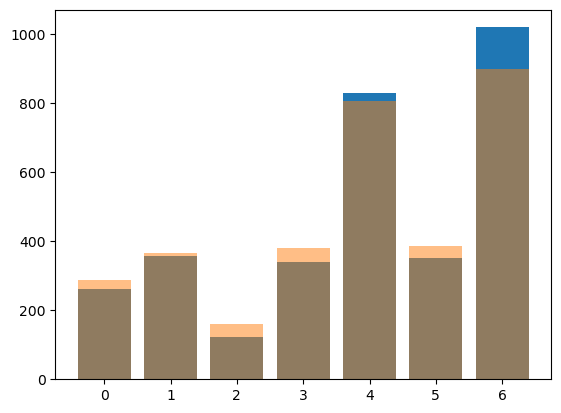

In [5]:
# start = 23:22 11/01/2023
# end = 17:00 13/01/2023
import matplotlib.pyplot as plt
from collections import Counter
c = dict(Counter(y_pred))
plt.bar(c.keys(),c.values())
d = dict(Counter(y_valid))
plt.bar(d.keys(),d.values(), alpha=0.5)
print(class_enc.inverse_transform([6]))

618
[1 4 1 ... 4 6 6]
[1 4 1 ... 4 5 6]
3934


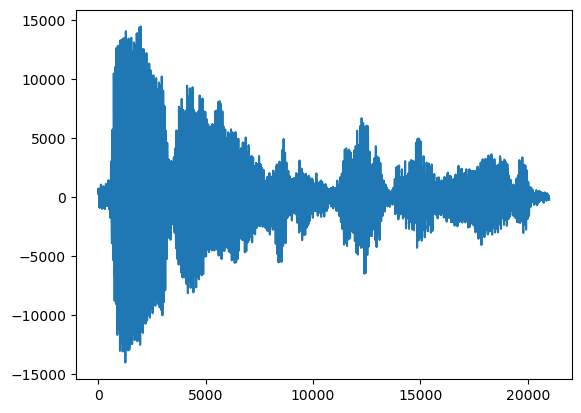

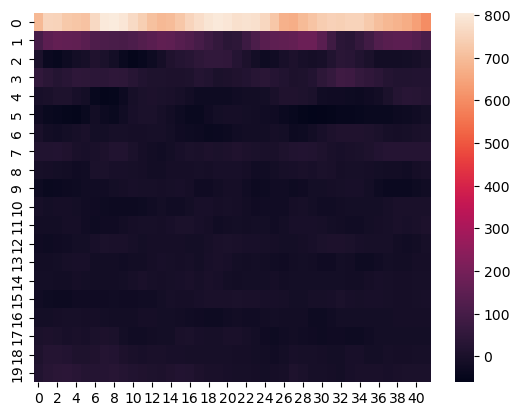

Id                                                                                     215
path                                     dsl_data/audio/speakers/2ojo7YRL7Gck83Z3/1b63b...
speakerId                                                                 2ojo7YRL7Gck83Z3
action                                                                            decrease
object                                                                                heat
Self-reported fluency level                                                         native
First Language spoken                                              English (United States)
Current language used for work/school                              English (United States)
gender                                                                              female
ageRange                                                                             22-40
label                                                                         decreaseheat

IndexError: index 3934 is out of bounds for axis 0 with size 3284

In [6]:
import seaborn as sns
A = 3
mask = y_pred != y_valid
s = sum(mask)
print(s)
bad = np.argsort(mask)[-s:]
print(y_pred)
print(y_valid)
print(validation_indices[bad[A]])
plt.plot(Xtime[validation_indices[bad[A]]])
plt.show()
sns.heatmap(librosa.feature.mfcc(Xtime[validation_indices[bad[A]]]))
plt.show()
print(df.loc[validation_indices[bad[A]]])
print(class_enc.inverse_transform([y_pred[validation_indices[bad[A]]]]))

In [ ]:
gender_gap = [df.loc[validation_indices[b],'gender'] for b in bad]
g = Counter(gender_gap)
print(g)

In [ ]:
plt.plot(pitch_per_audio[0])
plt.plot(pitch_per_audio[0]*(1.05946**12))

In [ ]:
plt.plot(pitch_per_audio[0]*(1/(2*1.05946)))
# acc = 0.8096; bal_acc = 0.7863 RF my pitchshifting
# acc = 0.8098; bal_acc = 0.7874